# Рекомендательные системы

Существуют различные подходы к построению рекомендательных систем: коллаборативный (User/Item Based kNN, Matrix factorization (ALS, SVD, FM, WR-MF, BPRMF), Neural collaborative filtering (NCF)), Learning to Rank (LTR: Pointwise, Pairwise(RankNet), Listwise(LambdaRank)), Sequential Recommendation (RNN, SASRec, FISSA), Collaborative Memory Networks (CMN), Collaborative Variational Autoencoder (CVAE), Reinforcement Learning (DDPG), Co-training recommendation, ... Многие описаны в хорошей обзорной статье на хабре ([часть 1](https://habr.com/ru/companies/prequel/articles/567648/), [часть 2](https://habr.com/ru/companies/prequel/articles/573880/)).

1. Выполните все задания в файле example.ipynb (см. example.zip) для данных example_data.csv. Добейтесь успешной проверки в конце файла.

2. Возьмите датасет вашего варианта (список см. ниже), сконвертируйте его в требуемую форму (см. example.zip) и запустите для него код файла example.ipynb. 

In [39]:
import pandas as pd
import numpy as np
import surprise, sklearn, sklearn.model_selection, tqdm

df = pd.read_json('renttherunway_final_data.json', lines=True)
df

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,66386,34dd,2252812,140lbs,10.0,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,"5' 9""",8,42.0,"May 18, 2016"
192540,fit,118398,32c,682043,100lbs,10.0,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,"5' 1""",4,29.0,"September 30, 2016"
192541,fit,47002,36a,683251,135lbs,6.0,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,"5' 8""",8,31.0,"March 4, 2016"
192542,fit,961120,36c,126335,165lbs,10.0,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,"5' 6""",16,31.0,"November 25, 2015"


In [40]:
d = df.copy()
df.rename({'rating':'buy'}, axis=1, inplace=True)
#df.rename({'user_id':'user_id'}, axis=1, inplace=True)
#df.rename({'item_id':'item_id'}, axis=1, inplace=True)
df['buy'] = 1
d = df.drop(columns=['fit', 'bust size', 'weight', 'rented for', 'review_text', 'body type', 'review_summary', 'category', 'height', 'size', 'age', 'review_date'])
d

,user_id,item_id,buy
0,420272,2260466,1
1,273551,153475,1
2,360448,1063761,1
3,909926,126335,1
4,151944,616682,1
...,...,...,...
192539,66386,2252812,1
192540,118398,682043,1
192541,47002,683251,1
192542,961120,126335,1


In [41]:
user_buy_counts = d.groupby('user_id')['item_id'].count()
item_buy_counts = d.groupby('item_id')['user_id'].count()

user_buys = user_buy_counts.values 
item_buys = item_buy_counts.values 

unique_user_buys, counts_user_buys = np.unique(user_buys, return_counts=True)
unique_item_buys, counts_item_buys = np.unique(item_buys, return_counts=True)

one_time_buyers = counts_user_buys[unique_user_buys == 1][0] if 1 in unique_user_buys else 0
max_user_buys = unique_user_buys.max()

one_time_items = counts_item_buys[unique_item_buys == 1][0] if 1 in unique_item_buys else 0
max_item_buyers = unique_item_buys.max()

print(f"Количество случайных покупателей (купили только 1 товар): {one_time_buyers}")
print(f"Максимальное количество товаров, купленных одним покупателем: {max_user_buys}")
print(f"Количество непопулярных товаров (купили только один раз): {one_time_items}")
print(f"Максимальное количество покупателей у самого популярного товара: {max_item_buyers}")

Количество случайных покупателей (купили только 1 товар): 71824
Максимальное количество товаров, купленных одним покупателем: 436
Количество непопулярных товаров (купили только один раз): 341
Максимальное количество покупателей у самого популярного товара: 2241


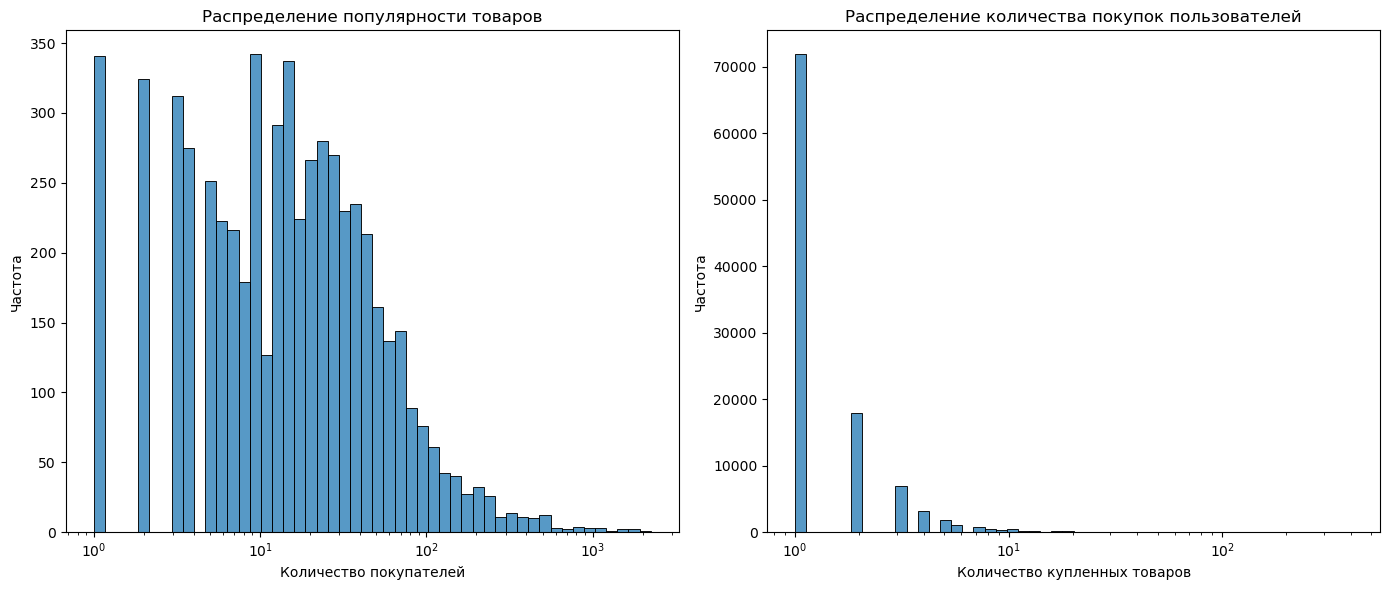

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Популярность товаров (кол-во уникальных покупателей у каждого товара)
popularity = d.groupby('item_id')['user_id'].nunique()

# 2. Количество покупок каждого пользователя (сколько разных товаров купил пользователь)
user_buys_count = d.groupby('user_id')['item_id'].nunique()

# Рисуем гистограммы
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(popularity, log_scale=True, bins=50)
plt.title('Распределение популярности товаров')
plt.xlabel('Количество покупателей')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(user_buys_count, log_scale=True, bins=50)
plt.title('Распределение количества покупок пользователей')
plt.xlabel('Количество купленных товаров')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

In [51]:
cold_start = True

all_users = np.unique(d['user_id'])
print('Общее число пользователей:', len(all_users))

# уменьшите, если вам не хватает оперативной памяти
train_size=4000
test_size=100

if cold_start:
    assert train_size+test_size < len(all_users)
    train_users, test_users = sklearn.model_selection.train_test_split(all_users, 
                    train_size=train_size, test_size=test_size, random_state=0)
else:
    train_users = np.random.choice(all_users, size=train_size, replace=False)
    assert test_size <= train_size
    test_users = np.random.choice(train_users, size=test_size, replace=False)

d_train = d.loc[np.isin(d['user_id'], train_users)].reset_index(drop=True)
d_test = d.loc[np.isin(d['user_id'], test_users)].reset_index(drop=True)
print(d_train.head(5))
print('Размер обучающей выборки', len(d_train))
print('Среднее число покупок у одного человека', len(d_train)/train_size)

# добавляем в d_train товары, которые пользователи не покупали и присваиваем им минимальный рейтинг
# у меня самый хороший результат получился, когда добавляешь столько же не купленных товаров, сколько
# в среднем покупают пользователи
toAdd_for_each_user = 30
toAdd = np.zeros((toAdd_for_each_user,3))
all_items = np.unique(np.concatenate((d_train['item_id'],d_test['item_id'])))
n_items = len(all_items)
print('Общее число товаров:', n_items)
np.random.seed(0)
for i in tqdm.tqdm(range(train_size)):
    user_id = train_users[i]
    ind_for_1_user = np.where(d_train['user_id'] == user_id)[0]
    buy = d_train.loc[ind_for_1_user,'item_id']
    
    not_buy = np.setdiff1d(all_items, buy)  # TODO!!!
    sampled_not_buy = np.random.choice(not_buy, size=toAdd_for_each_user, replace=False)
    toAdd[:,0] = user_id
    toAdd[:,1] = sampled_not_buy  # TODO!!!

    if i == 3:
        print(f'\nПользователь {user_id}')
        print(f'  Купленные товары: {list(buy[:10])} ...')
        print(f'  Добавленные (не купленные) товары: {list(sampled_not_buy[:10])} ...')
    
    if not cold_start and len(buy) > 1:
        # выбрасываем из train часть купленных товаров, чтобы они попали в тест
        d_train.drop(ind_for_1_user[len(ind_for_1_user)//2:], axis=0, inplace=True)
    d_train = pd.concat((d_train, pd.DataFrame(toAdd, columns=d_train.columns)), axis=0)
    d_train.reset_index(drop=True, inplace=True)
print('Размер расширенной обучающей выборки', len(d_train))

Общее число пользователей: 105571
   user_id  item_id  buy
0   845755   387552    1
1   211039  1226293    1
2   547377   199457    1
3   979081  1689615    1
4   912090   182915    1
Размер обучающей выборки 7426
Среднее число покупок у одного человека 1.8565
Общее число товаров: 2769


  2%|█▋                                                                             | 85/4000 [00:00<00:04, 849.13it/s]


Пользователь 442017
  Купленные товары: [660136.0] ...
  Добавленные (не купленные) товары: [2345674, 2845075, 2304087, 1097644, 1954824, 1678888, 1310632, 1083523, 1225471, 2390187] ...


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:10<00:00, 386.14it/s]

Размер расширенной обучающей выборки 127426


In [54]:
# Порядок столбцов для surprise очень важен: user_id, item_id и рейтинг
surprise_d_train = surprise.Dataset.load_from_df(d_train[['user_id','item_id','buy']], 
                        surprise.Reader(rating_scale=(0,1))).build_full_trainset()
method = surprise.SVD()
method.fit(surprise_d_train)

In [59]:
def get_true_test_for_one_user(d_test, user_id):
    if cold_start:
        # пользователь не встречается в train вовсе - добавляем в test все товары
        extended_true_test = np.zeros(n_items)
        ind_for_1_user = d_test['user_id'] == user_id
        buy = d_test.loc[ind_for_1_user, 'item_id'].values  # TODO!!!
        extended_true_test[np.isin(all_items, buy)] = 1  # TODO!!! (см. np.isin)
        return extended_true_test, all_items
    else:
        # тестируем только на купленных товарах данного пользователя в test 
        # и на тех некупленных товарах, факты о некупли которых не содержатся в train
        ind_for_1_user = d_test['user_id'] == user_id
        buy_test = np.unique(d_test.loc[d_test['user_id'] == user_id, 'item_id'])
        buy_train = np.unique(d_train.loc[(d_train['user_id']==user_id) & (d_train['buy']==1), 'item_id'])
        all_buy = np.union1d(buy_train, buy_test)
        not_buy = np.setdiff1d(all_items, all_buy)
        not_buy_train = np.unique(d_train.loc[(d_train['user_id']==user_id) & (d_train['buy']==0), 'item_id'])
        not_buy_test = np.setdiff1d(not_buy, not_buy_train)
        all_items_test = np.union1d(buy_test, not_buy_test)
        extended_true_test = np.zeros(len(all_items_test))
        extended_true_test[np.isin(all_items_test, buy_test)] = 1
        return extended_true_test, all_items_test

def get_predicted_test_for_one_user(method, user_id, all_items_for_1_user):
    extended_predicted_test = np.zeros(len(all_items_for_1_user))
    for i, item_id in enumerate(all_items_for_1_user):
        extended_predicted_test[i] = method.predict(user_id, item_id).est  # TODO!!!
    return extended_predicted_test

method.predict(442017, 10)

Prediction(uid=442017, iid=10, r_ui=None, est=0.043224643505082254, details={'was_impossible': False})

In [62]:
def AP_at_k(predictions_for_1_user, true_for_1_user, k):
    max_ind = np.argpartition(-predictions_for_1_user, k)[:k]
    max_predictions = predictions_for_1_user[max_ind]
    true = true_for_1_user[max_ind]
    # сортируем максимальные k предсказаний
    i = np.argsort(-max_predictions)
    max_predictions = max_predictions[i]
    true = true[i]
    # считаем AP, усредняя Precision для всех 1
    ones_ind = np.where(true == 1)[0]
    if len(ones_ind) == 0: return 0
    precision = np.zeros(len(ones_ind))
    for j in range(len(ones_ind)):
        ind_of_one = ones_ind[j]
        precision[j] = np.sum(true[:ind_of_one + 1]) / (ind_of_one + 1)  # TODO!!!
    return np.mean(precision)

k = 100
APs = np.zeros(test_size)
for i in tqdm.tqdm(range(test_size)):
    user_id = test_users[i]
    true_for_1_user, all_items_for_1_user = get_true_test_for_one_user(d_test, user_id) # TODO!!!
    predictions_for_1_user = get_predicted_test_for_one_user(method, user_id, all_items_for_1_user) # TODO!!!
    APs[i] = AP_at_k(predictions_for_1_user, true_for_1_user, k)

MAP = np.mean(APs)
print(f'MAP@{k} =', MAP)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.56it/s]

MAP@100 = 0.04806313533471921


3. Запрограммируйте случайные рекомендации, а затем одинаковые для всех пользователей самые популярные. Составьте таблицу с двумя строчками: cold start, hot start, и четырьмя столбцами: random, popular, kNN, SVD. Заполните ее значениями метрики качества MAP@k для k=5 (или больше, если много нулевых значений).

4. Для метода kNN, cold_start=True и False для каждого пользователя из test выведите процент товаров, для которых предсказание рейтинга совпадает с kNN.default_prediction(). Что означают полученные результаты?

4. Возьмите одного пользователя из test для cold_start=True и выясните, отличаются ли первые k рекомендаций для него по методу kNN от самых популярных. Если да, то объясните почему.

5. Найдите пользователя из test для cold_start=False у которого значение details['actual_k'], возвращаемое функцией predict отлично от нуля. Найдите в списке его рекомендаций позиции товаров, которые покупали его соседи.

## [Варианты датасетов](https://cseweb.ucsd.edu/~jmcauley/datasets.html):
1. Twitch. [Описание](https://github.com/JRappaz/liverec). [Данные](https://drive.google.com/drive/folders/1BD8m7a8m7onaifZay05yYjaLxyVV40si)
2. [Food.com Recipe & Review Data](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions)
3. [Amazon Product Reviews](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/). Нужно выбрать только одну категорию из таблицы "Per-category data"
4. [Marketing Bias data](https://github.com/MengtingWan/marketBias). Выберите один из двух датасетов: ModCloth и Electronics
5. [Google Local Reviews (2021)](https://jiachengli1995.github.io/google/index.html). 
6. [Google Restaurants](https://www.kaggle.com/datasets/hwwang98/google-restaurants)
7. [Steam Video Game and Bundle Data](https://cseweb.ucsd.edu/~jmcauley/datasets.html#steam_data)
8. [Goodreads Book Reviews](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home)
9. [Clothing Fit Data](https://cseweb.ucsd.edu/~jmcauley/datasets.html#clothing_fit)
10. [Product Exchange/Bartering Data](http://swapit.github.io/)
11. [Behance Community Art Data](https://drive.google.com/drive/folders/0B9Ck8jw-TZUEc3NlMjVXdDlPU1k?resourcekey=0-6_8ykn0o4fLc5fuTEm91xA)
12. [Social Recommendation Data](https://cseweb.ucsd.edu/~jmcauley/datasets.html#social_data)
13. [Social circles data](https://cseweb.ucsd.edu/~jmcauley/datasets.html#socialcircles). Нужно взять Google Plus
14. [MovieLens](https://grouplens.org/datasets/movielens/)
15. [WikiLens](https://grouplens.org/datasets/wikilens/)
16. [Book-Crossing](https://grouplens.org/datasets/book-crossing/)
17. [Book Genome Dataset](https://grouplens.org/datasets/book-genome/)
18. [Jester](https://goldberg.berkeley.edu/jester-data/)
19. [Rating Disposition](https://grouplens.org/datasets/rating-disposition-2023/)
20. [Learning from Sets of Items in Recommender Systems](https://grouplens.org/datasets/learning-from-sets-of-items-2019/)
21. [User personality and user satisfaction](https://grouplens.org/datasets/personality-2018/)
22. [Investigating Serendipity](https://grouplens.org/datasets/serendipity-2018/)
23. [Delicious Bookmarks](https://grouplens.org/datasets/hetrec-2011/)
24. [Last.FM](https://grouplens.org/datasets/hetrec-2011/)